# data

Load OHLC data from cryptocurrency exchange Poloniex

In [1]:
from vectorbt import data, graphics
from datetime import datetime
from importlib import reload
import pytz
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)

In [2]:
ohlc_df = data.load_cryptopair('USDT_BTC', data.ago_dt(days=30), data.now_dt())
ohlc_df.head()

done. 2.06s


,O,H,L,C,V
date,,,,,
2017-10-23 23:50:00,5904.999999,5918.0,5887.999999,5888.900000,141400.135344
2017-10-23 23:55:00,5888.900000,5900.0,5888.501000,5900.000000,60929.905017
2017-10-24 00:00:00,5900.000000,5900.0,5880.000000,5880.000000,21346.555666
2017-10-24 00:05:00,5879.526400,5880.0,5851.000000,5880.000000,75139.448821
2017-10-24 00:10:00,5865.000010,5880.0,5865.000010,5874.000001,84400.865553


In [3]:
# No future data
rate_sr = ohlc_df.O

    count         mean        std      min     25%        50%     75%  \
O  8639.0  6850.891682  809.30328  5302.64  6140.0  6990.0001  7417.9   

           max  
O  8383.465575  


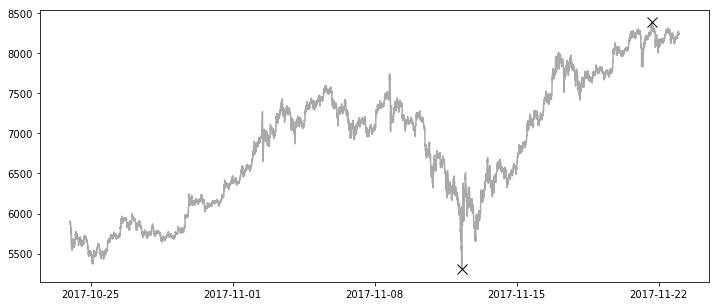

In [4]:
graphics.plot_line(rate_sr)

# indicators

Calculate simple moving averages

In [5]:
from vectorbt import indicators

In [6]:
fast_ma_sr = indicators.EMA(rate_sr, 100)
slow_ma_sr = indicators.EMA(rate_sr, 300)

# signals

In [7]:
from vectorbt import signals, vector
import numpy as np

First condition: Go long whenever fast SMA is over slow SMA, while go short when opposite occurs.

In [8]:
ma_evector = signals.DMAC_evector(fast_ma_sr, slow_ma_sr)
ma_xvector = signals.DMAC_xvector(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [9]:
ma_evector = vector.first(ma_evector)
ma_xvector = vector.first(ma_xvector)

Second condition: Go short whenever price drops by 5%.

In [10]:
trailstop_xvector = signals.trailstop_xvector(rate_sr, ma_evector, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and reduce.

In [11]:
ma_xvector = vector.first(vector.OR(ma_xvector, trailstop_xvector))

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations

# positions

In [12]:
from vectorbt import positions

Generete positions out of both vectors (merge and reduce)

In [13]:
pos_sr = positions.from_vectors(rate_sr, ma_evector, ma_xvector)
pos_sr.head()

date
2017-10-25 21:20:00    1
2017-10-27 13:15:00   -1
2017-10-29 07:00:00    1
2017-11-04 00:55:00   -1
2017-11-04 13:55:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

   count        mean         std       min        25%        50%         75%  \
O   22.0  117.301671  456.622442 -957.1754 -36.933849  81.534339  141.925666   

           max  
O  1363.143512  


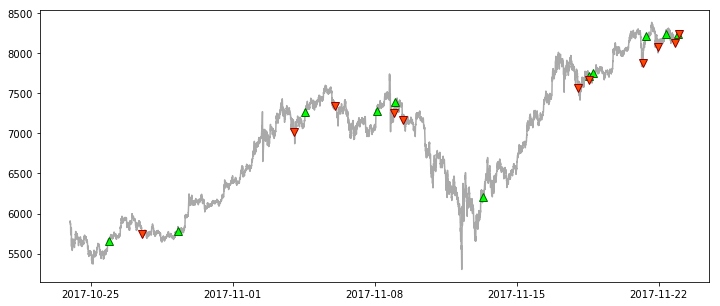

In [14]:
positions.plot(rate_sr, pos_sr)

# returns

In [15]:
from vectorbt import returns

Generate % returns out of positions. Takes into account fees.

In [16]:
posret_sr = returns.from_positions(rate_sr, pos_sr, 0.0025)
posret_sr.head()

date
2017-10-25 21:20:00   -0.002500
2017-10-27 13:15:00    0.013933
2017-10-29 07:00:00   -0.002500
2017-11-04 00:55:00    0.210157
2017-11-04 13:55:00   -0.002500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [17]:
returns.on_hold(rate_sr, 0.0015)

date
2017-10-23 23:50:00   -0.001500
2017-11-22 23:40:00    0.392205
dtype: float64

   count      mean       std       min       25%     50%     75%       max
0   22.0  0.015835  0.064699 -0.032891 -0.002744 -0.0025 -0.0025  0.216712


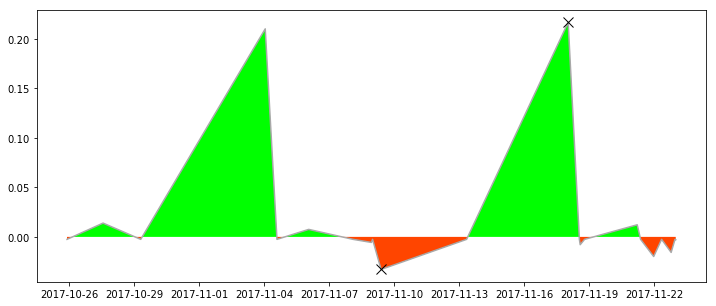

In [18]:
returns.plot(posret_sr)

# equity

In [19]:
from vectorbt import equity

Generate equity in base and quote currency from position returns

In [20]:
equity_df = equity.from_returns(rate_sr, posret_sr)
equity_df.head()

,base,quote
date,,
2017-10-23 23:50:00,NaN,NaN
2017-10-23 23:55:00,NaN,NaN
2017-10-24 00:00:00,NaN,NaN
2017-10-24 00:05:00,NaN,NaN
2017-10-24 00:10:00,NaN,NaN


Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count       mean         std         min         25%        50%  \
0  8093.0  22.332138  323.881133 -638.395846 -186.457046 -77.046707   

          75%          max  
0  275.293231  1334.493294  


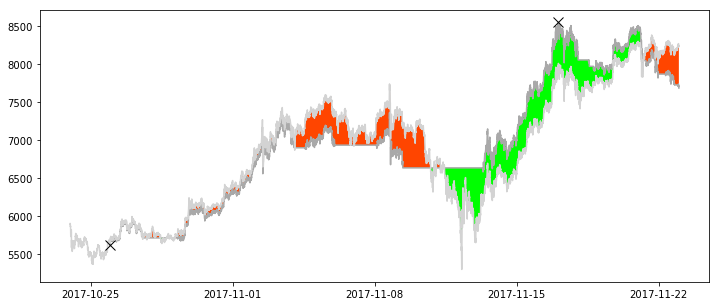

quote
    count      mean       std       min       25%       50%       75%  \
0  8093.0  0.003952  0.046507 -0.087746 -0.023073 -0.011944  0.038251   

        max  
0  0.251666  


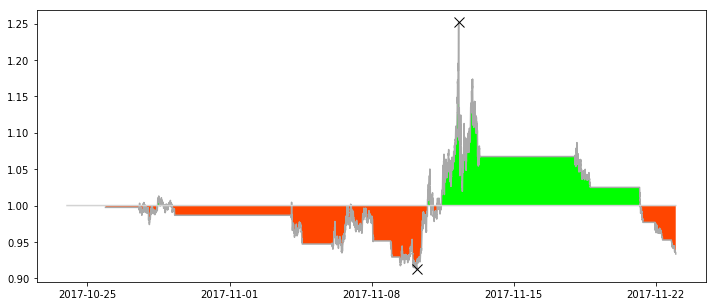

In [21]:
equity.plot(rate_sr, equity_df)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [22]:
eqd_sr = equity.diffs(posret_sr)
eqd_sr.head()

date
2017-10-27 13:15:00    0.013898
2017-11-04 00:55:00    0.212021
2017-11-06 01:05:00    0.009217
2017-11-08 22:30:00   -0.006856
2017-11-09 09:15:00   -0.039933
dtype: float64

# performance

In [23]:
from vectorbt import performance

Print summary of multiple KPIs applied on equity diffs

In [24]:
performance.print_summary(eqd_sr)

{
  "performance": {
    "profit": 0.39435078269334745,
    "averages": {
      "trade": 0.03585007115394068,
      "gain": 0.1012296519725199,
      "loss": 0.018632912861542006
    },
    "winrate": 0.45454545454545453,
    "payoff": 5.43284094788293,
    "PF": 4.527367456569108,
    "RF": 7.331990171200959
  },
  "risk/return profile": {
    "sharpe": 0.36055730265907526,
    "sortino": 2.578518962809027,
    "maxdd": 0.053784957901648944
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 4 levels:**

| Level | Motivation | Module | Map structure |
|-|-|-|-|
| 1 | Calculate equity diffs | `seriesmap` | `[(,)]` |
| 2 | Calculate KPIs on equity diffs and compare | `nummap` | `pd.Series` |
| 3 | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Find patterns by building a heatmap | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies

## L1
## seriesmap

In [25]:
from vectorbt.optimizer.gridsearch import params, seriesmap, mapper

Calculate equity diffs for a range of EMA combinations

    1. Precalculate all EMAs

In [42]:
# Init
ma_func = lambda window: indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 1000, 10
fees = 0.0025

# Cache moving averages
param_range = params.range_params(min_ma, max_ma, step)
mamap = dict(seriesmap.from_func(ma_func, param_range))

cores: 4
processes: 3
starmap: False
calcs: 101 ..
done. 0.24s


    2. For each EMA combination, generate respective equity diffs

In [43]:
# Func
def ma_eqdfunc(fast_ma, slow_ma):
    # Requires multiple layers of calculations
    fast_ma_sr = mamap[fast_ma]
    slow_ma_sr = mamap[slow_ma]
    entries = vector.first(signals.DMAC_evector(fast_ma_sr, slow_ma_sr))
    exits = vector.first(signals.DMAC_xvector(fast_ma_sr, slow_ma_sr))
    pos_sr = positions.from_vectors(rate_sr, entries, exits)
    posret_sr = returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = equity.diffs(posret_sr)
    return eqd_sr

# Params
param_space = params.combine_rep_params(min_ma, max_ma, step, 2)

In [44]:
ma_eqdmap = seriesmap.from_func(ma_eqdfunc, param_space)

cores: 4
processes: 3
starmap: True
calcs: 5151 ..
done. 14.43s


Generate equity diffs for random positions. Number of positions is the same as for EMA, to be comparable.

In [45]:
# Func
def random_eqdfunc(n):
    entries = signals.random_vector(rate_sr, n)
    exits = signals.random_vector(rate_sr, n, excl_vector=entries)
    pos_sr = positions.from_vectors(rate_sr, entries, exits)
    posret_sr = returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = equity.diffs(posret_sr)
    return eqd_sr

# Params
param_range = np.array(mapper.map(lambda sr: len(sr.index), list(zip(*ma_eqdmap))[1]))+1

cores: 4
processes: 3
starmap: False
calcs: 5151 ..
done. 3.82s


In [46]:
random_eqdmap = seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 5151 ..
done. 15.60s


## L2
## nummap

Apply KPI on each equity diffs series

In [47]:
from vectorbt.optimizer.gridsearch import nummap

In [48]:
ma_exp_sr = nummap.from_seriesmap(ma_eqdmap, performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 ..
done. 3.49s
min (11, 141): -0.0019615609262
max (721, 1001): 0.144570386394


In [49]:
ma_sharpe_sr = nummap.from_seriesmap(ma_eqdmap, performance.sharpe)

cores: 4
processes: 3
starmap: False
calcs: 5151 ..
done. 3.75s
min (1, 11): -0.333798983494
max (791, 931): 0.934443125457


In [50]:
random_exp_sr = nummap.from_seriesmap(random_eqdmap, performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 ..
done. 3.96s
min 1: -0.172695070533
max 1: 0.433809948494


Compare quantile distributions of EMA and random strategy KPIs

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.084926  0.035108 -0.001962  0.074526  0.095564  0.103898   
benchmark  5151.0  0.052306  0.060973 -0.172695  0.011109  0.039469  0.080937   

               max  
nummap     0.14457  
benchmark  0.43381  


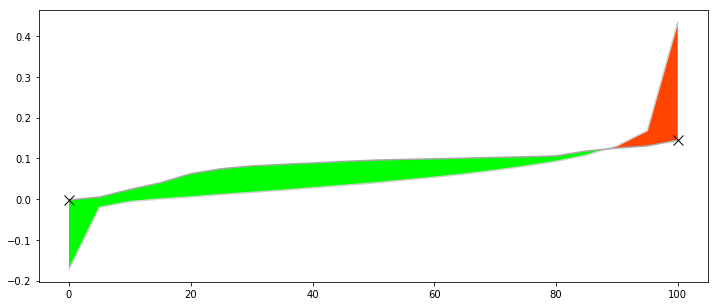

In [51]:
nummap.compare_quantiles(ma_exp_sr, random_exp_sr)

Compare KPI distribution to that of random map

            count      mean       std       min       25%       50%       75%  \
nummap     5050.0  0.084926  0.035108 -0.001962  0.074526  0.095564  0.103898   
benchmark  5151.0  0.052306  0.060973 -0.172695  0.011109  0.039469  0.080937   

               max  
nummap     0.14457  
benchmark  0.43381  


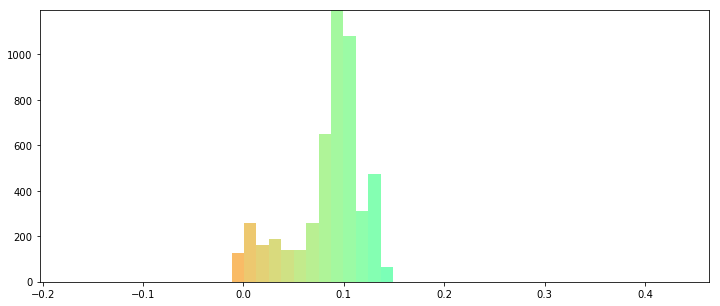

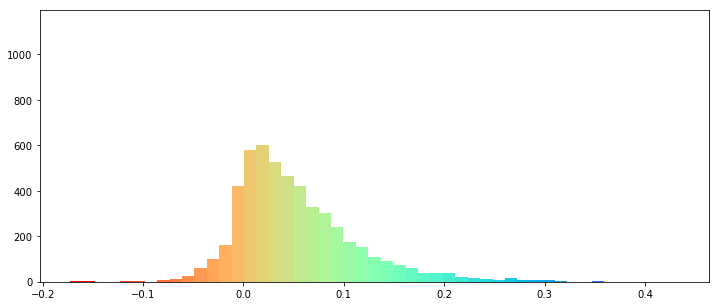

In [52]:
from matplotlib import pyplot as plt
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
nummap.compare_hists(ma_exp_sr, random_exp_sr, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100

In [53]:
from vectorbt.optimizer.gridsearch import scoremap

In [54]:
ma_scoremap_sr = scoremap.from_nummaps([ma_exp_sr, ma_sharpe_sr], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 1): 1.0
max (761, 961): 99.6804172956


## L4
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [55]:
from vectorbt.optimizer.gridsearch import matrix
import pandas as pd

In [56]:
ma_matrix_df = matrix.from_nummap(ma_exp_sr, symmetric=True).fillna(0)

done. 1.89s


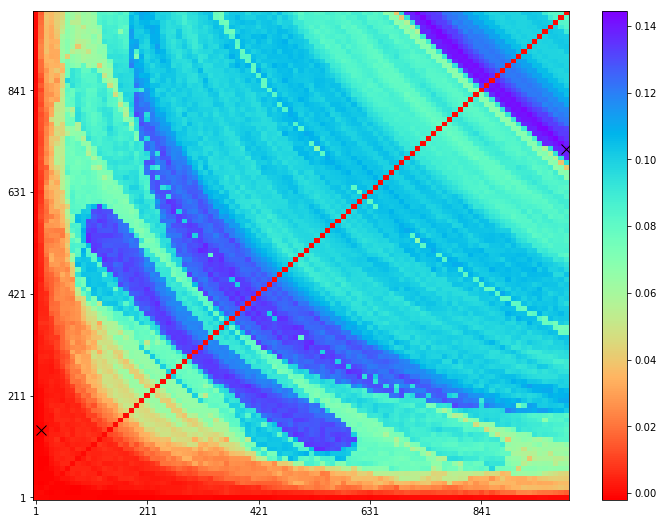

In [57]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
matrix.plot(ma_matrix_df, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)